# Census OTC retention predication with XGBoost

As a collateral benefit both product and marketing would like to understand which customer attributes or activities have the highest impact on retention. 

We want to know the importance of features, and use SHAP values to understand XGBoost model predictions. 

In [1]:
from sklearn.model_selection import train_test_split
import xgboost
import shap
import numpy as np
import matplotlib.pylab as pl

# print the JS visualization code to the notebook
shap.initjs()

## Load dataset

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv('capsule.csv')

X_display = df.drop('retained', axis=1)
y_display = df['retained']

le_cols = [
    'order_market',
    'order_source', 
    'account_source',
    'patient_gender',
    'patient_primary',
    'first_order_source'
]

label_encodes = []
for c in le_cols:
    le = LabelEncoder()
    df[c] = le.fit_transform(df[c])
    label_encodes.append(le)

X = df.drop('retained', axis=1)
y = df['retained']

In [3]:
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

## Train the model

In [4]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}
model = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=50)

[0]	test-logloss:0.57788
[100]	test-logloss:0.28896
[200]	test-logloss:0.21451
[300]	test-logloss:0.19013
[400]	test-logloss:0.18196
[500]	test-logloss:0.17932
[600]	test-logloss:0.17830
[700]	test-logloss:0.17754
[800]	test-logloss:0.17681
[896]	test-logloss:0.17649


## Classic feature attributions

Here we try out the global feature importance calcuations that come with XGBoost. 

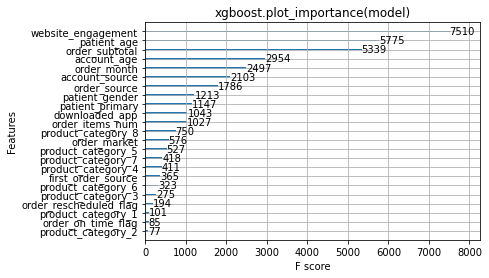

In [5]:
xgboost.plot_importance(model)
pl.title("xgboost.plot_importance(model)")
pl.show()

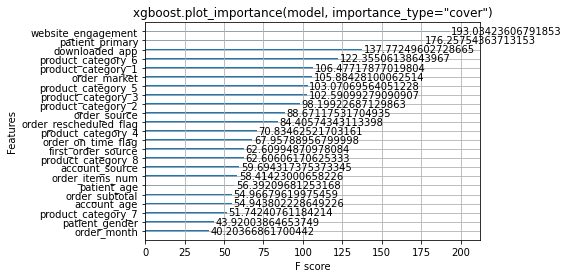

In [6]:
xgboost.plot_importance(model, importance_type="cover")
pl.title('xgboost.plot_importance(model, importance_type="cover")')
pl.show()

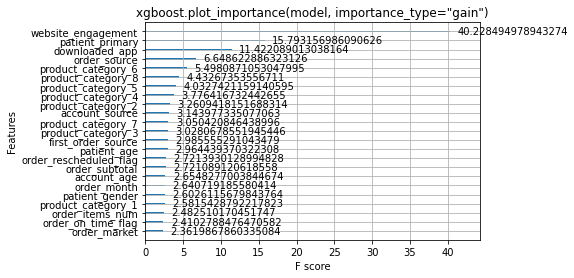

In [7]:
xgboost.plot_importance(model, importance_type="gain")
pl.title('xgboost.plot_importance(model, importance_type="gain")')
pl.show()

## Explain predictions

Here we use the Tree SHAP implementation integrated into XGBoost to explain the entire dataset.

In [8]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

### Visualize a single prediction

Note that we use the "display values" data frame so we get nice strings instead of category codes. 

In [9]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_display.iloc[0,:])

### Visualize many predictions

To keep the browser happy we only visualize 1,000 individuals.

In [10]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_display.iloc[:1000,:])

## Bar chart of mean importance

This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

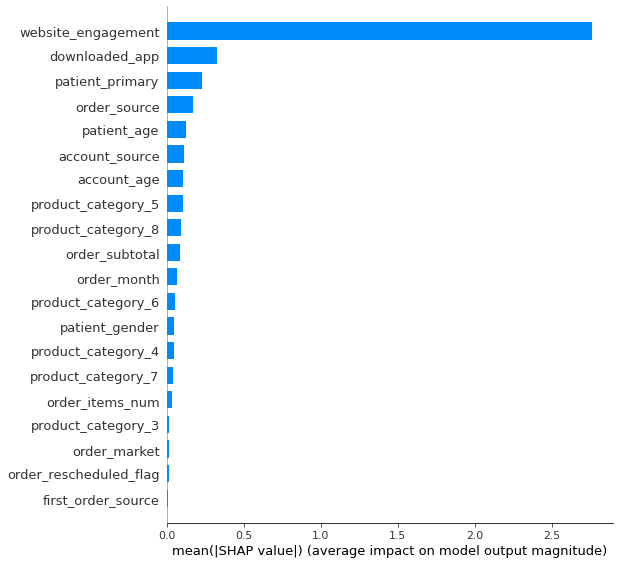

In [11]:
shap.summary_plot(shap_values, X_display, plot_type="bar")

## SHAP Summary Plot

Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the relationship feature has more total model impact than the captial gain feature, but for those samples where capital gain matters it has more impact than age. In other words, capital gain effects a few predictions by a large amount, while age effects all predictions by a smaller amount.

Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

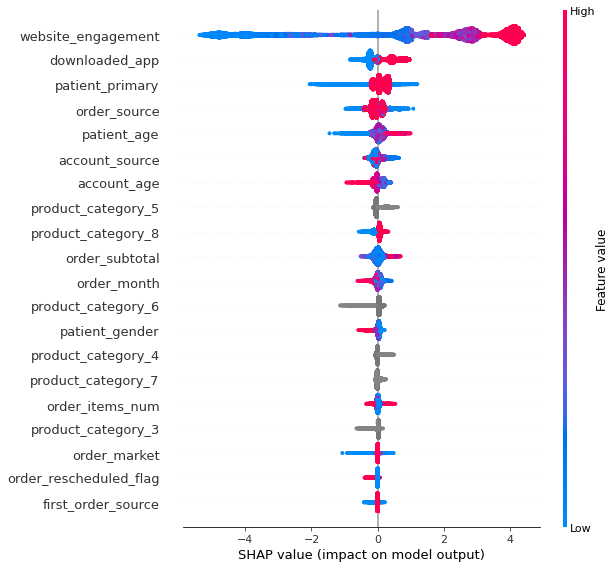

In [12]:
shap.summary_plot(shap_values, X)

## SHAP Dependence Plots

SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


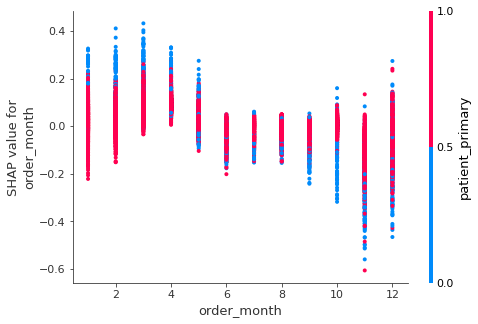

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


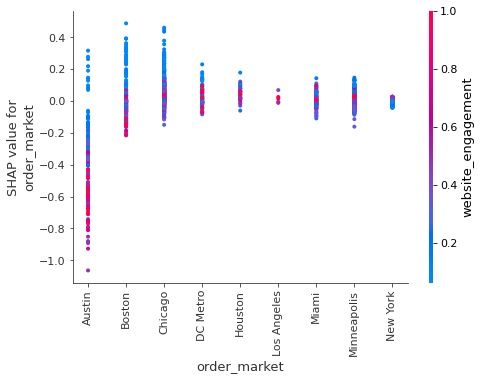

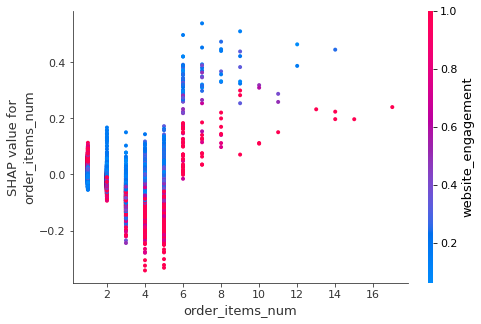

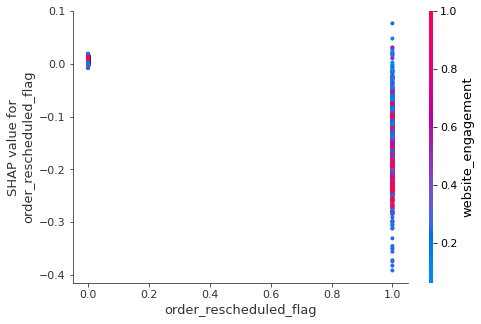

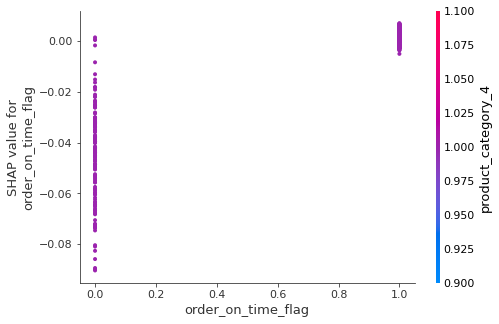

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


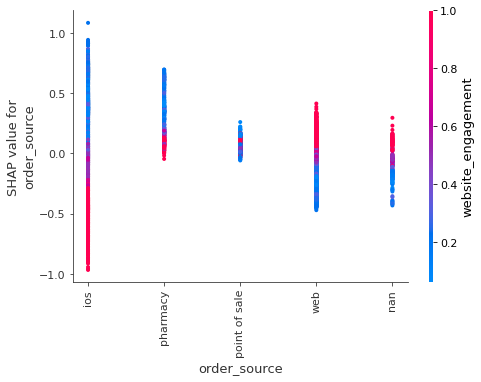

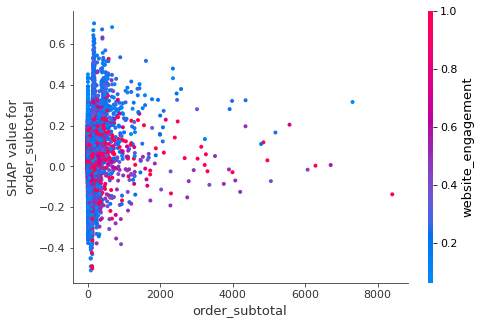

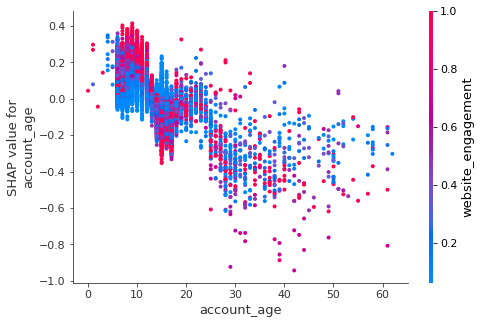

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


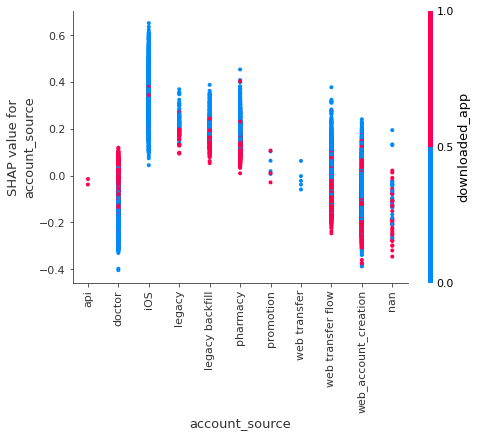

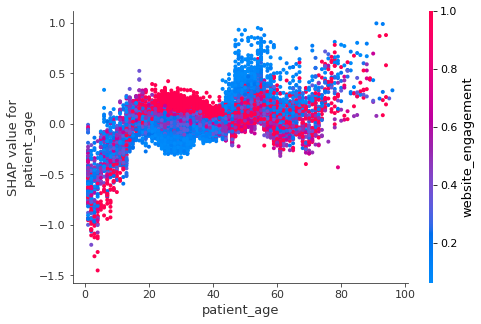

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


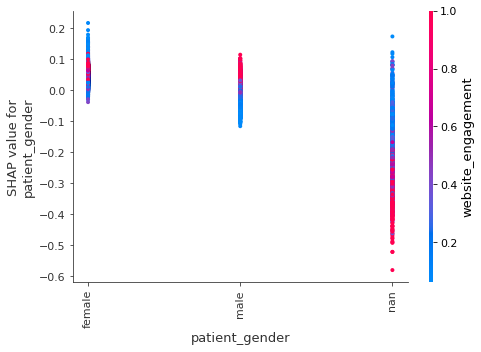

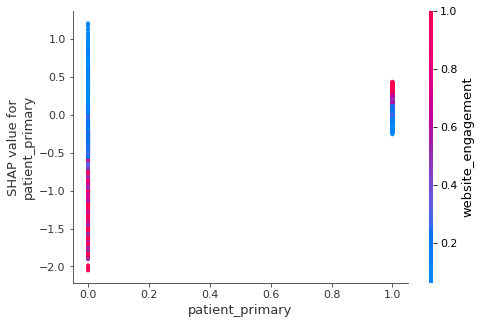

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


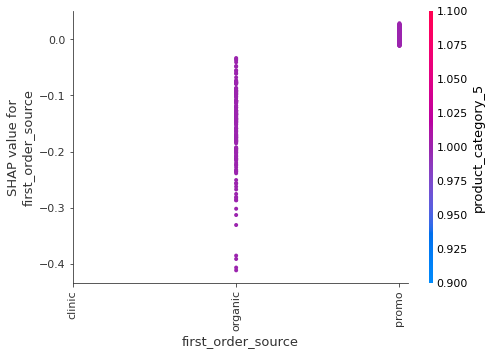

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


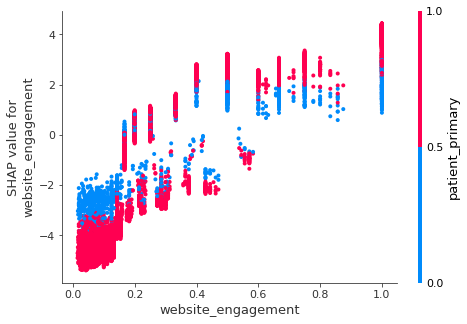

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


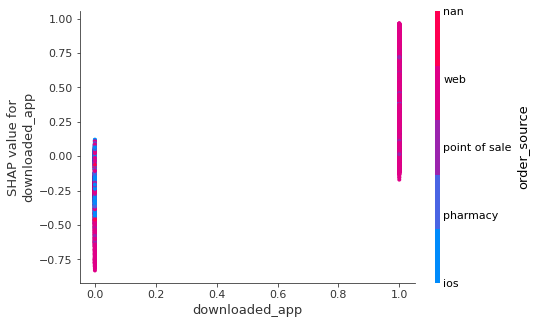

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


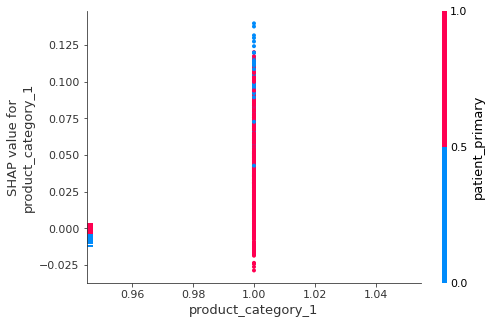

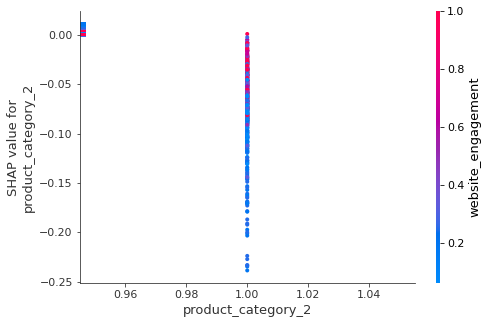

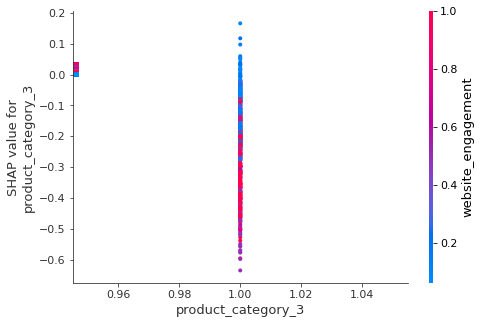

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


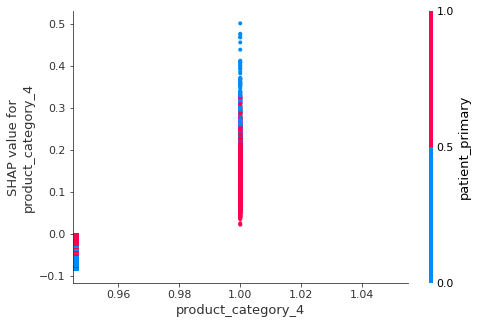

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


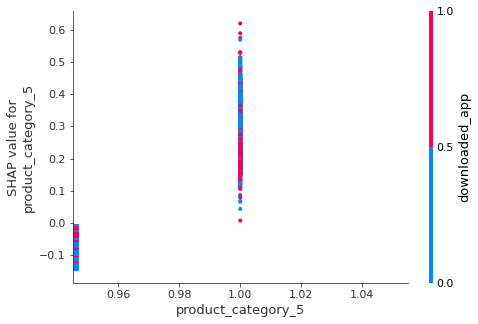

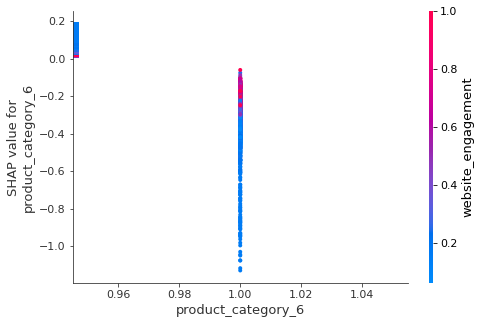

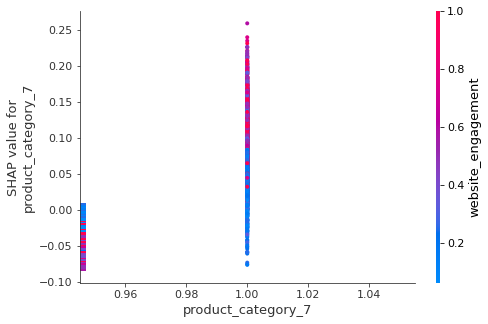

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


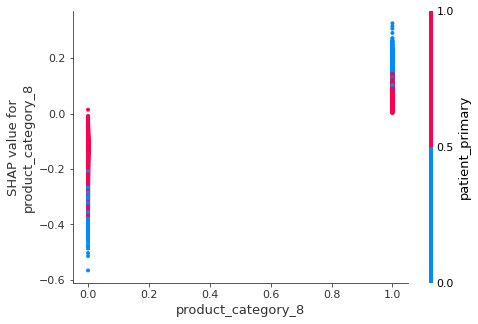

In [13]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X_display)

# Future Work
- Rule Learning
- Tune model
- Featue Engineer